<a href="https://colab.research.google.com/github/johanhoffman/DD2365_VT25/blob/main/PeriodicBC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About the code

In [1]:
# Copyright (C) 2019 Johan Hoffman (jhoffman@kth.se)


# Setup Environment

In [2]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-release-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# Define domain and mesh

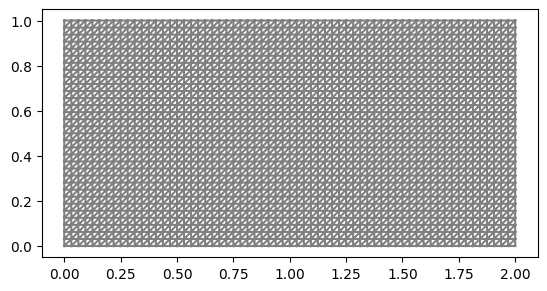

In [3]:
# Define domain
L = 2
H = 1

# Define subdomains
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0)

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], L)

class Lower(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], H)

left = Left()
right = Right()
lower = Lower()
upper = Upper()

resolution = 32

# Generate mesh
mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)

# Define mesh functions
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
lower.mark(boundaries, 3)
upper.mark(boundaries, 4)

# Define periodic domain
class PeriodicBoundary(SubDomain):

    # Left boundary is "target domain" G
    def inside(self, x, on_boundary):
        return bool(x[0] < DOLFIN_EPS and x[0] > -DOLFIN_EPS and on_boundary)

    # Map right boundary (H) to left boundary (G)
    def map(self, x, y):
        y[0] = x[0] - L
        y[1] = x[1]

plt.figure()
plot(mesh)
plt.show()

# Define approximation spaces

In [4]:
# Generate finite element spaces
V = VectorFunctionSpace(mesh, "Lagrange", 1, constrained_domain=PeriodicBoundary())
Q = FunctionSpace(mesh, "Lagrange", 1, constrained_domain=PeriodicBoundary())

# Define trial and test functions
u = TrialFunction(V)
p = TrialFunction(Q)
v = TestFunction(V)
q = TestFunction(Q)

# Define boundary conditions

In [5]:
# Define boundary conditions
class DirichletBoundaryLower(SubDomain):
    def inside(self, x, on_boundary):
        return bool(x[1] < DOLFIN_EPS and on_boundary)

class DirichletBoundaryUpper(SubDomain):
    def inside(self, x, on_boundary):
        return bool(x[1] > (H - DOLFIN_EPS) and on_boundary)

class DirichletBoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return bool(x[0] < DOLFIN_EPS and on_boundary)

class DirichletBoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return bool(x[0] > (L - DOLFIN_EPS) and on_boundary)

dbc_lower = DirichletBoundaryLower()
dbc_upper = DirichletBoundaryUpper()
dbc_left = DirichletBoundaryLeft()
dbc_right = DirichletBoundaryRight()

bcu0 = DirichletBC(V, (-1.0,0), dbc_lower)
bcu1 = DirichletBC(V, (1.0,0), dbc_upper)

bcu = [bcu0, bcu1]

bcp = []

# Define method parameters

In [6]:
# Define functions
u0 = Function(V)
u1 = Function(V)
p0 = Function(Q)
p1 = Function(Q)

# Set parameters
num_nnlin_iter = 5
prec = "amg" if has_krylov_solver_preconditioner("amg") else "default"

# Time step length
dt = 0.25*mesh.hmin()

# Parameters for numerical stabilizatio
d1 = 4*mesh.hmin()
d2 = 2*mesh.hmin()
d3 = 1e-4*mesh.hmin()

nu = 1.0e-3

# Define measure for boundary inntegration
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

# Define variational problem

In [7]:
# Define variational problem

# Stabilization parameters
h = CellDiameter(mesh);
u_mag = sqrt(dot(u1,u1))
d1 = 1.0/sqrt((pow(1.0/dt,2.0) + pow(u_mag/h,2.0)))
d2 = h*u_mag

# Mean velocities for trapozoidal time stepping
um = 0.5*(u + u0)
um1 = 0.5*(u1 + u0)

# Momentum variational equation on residual form
Fu = inner((u - u0)/dt + grad(um)*um1, v)*dx - p1*div(v)*dx + nu*inner(grad(um), grad(v))*dx \
    + d1*inner((u - u0)/dt + grad(um)*um1 + grad(p1), grad(v)*um1)*dx + d2*div(um)*div(v)*dx
au = lhs(Fu)
Lu = rhs(Fu)

# Continuity variational equation on residual form
Fp = d1*inner((u1 - u0)/dt + grad(um1)*um1 + grad(p), grad(q))*dx + div(um1)*q*dx + + d3*p*q*dx
ap = lhs(Fp)
Lp = rhs(Fp)

# Triple decomposition

In [8]:
import scipy.linalg.lapack as la
import numpy as np

def triple_decomposition(grad_u):
    new_grad = np.array([[0,0,0],
                         [0,0,0],
                         [0,0,0]])
    for i in range(2):
      for j in range(2):
        new_grad[i,j] = grad_u[i,j]
    def dselect(arg1,arg2): return (arg2==0)
    T = la.dgees(dselect,new_grad,sort_t = 1)[0]
    sh = np.linalg.norm([T[0,1],T[0,2],T[1,2]+T[2,1]])
    el = np.linalg.norm(np.diag(T))
    rr = np.sqrt(2*min(abs(T[1,2]),abs(T[2,1]))**2)
    return sh, el, rr

# Set I/O variables

In [9]:
# Open files
file_u = File("results-Euler/u.pvd")
file_p = File("results-Euler/p.pvd")

# Set plot frequency
plot_time = 0
plot_freq = 40

# Time stepping algorithm

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_b69f3cb22346b85b56a3f69c58532866cb62c4d9

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    2
  Coefficients:              '[f_13, f_16]'
  Unique elements:           'Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 10
INFO:FFC:  quadrature_degree: 10
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.314754 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:----------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_97b45861552b3837707f31fcac691c48c1c2dab1

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    3
  Coefficients:              '[f_13, f_16, f_22]'
  Unique elements:           'Vector<2 x CG1(?,?)>, CG1(?,?)'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 10
INFO:FFC:  quadrature_degree: 10
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0796592 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:----------------

Time t = 0.011048543456039806


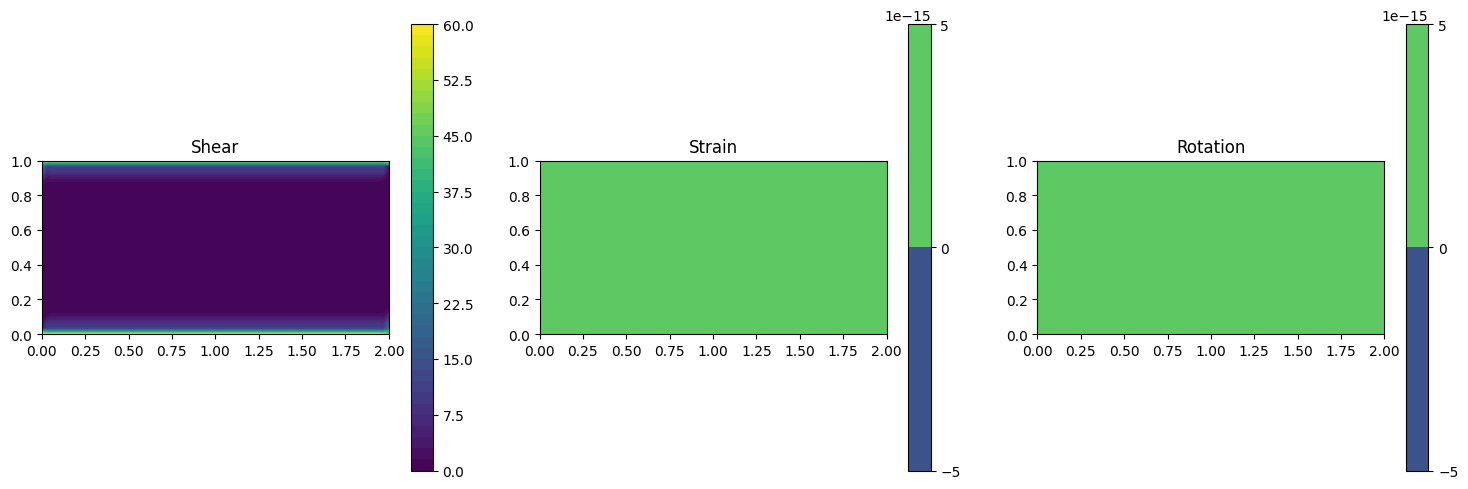

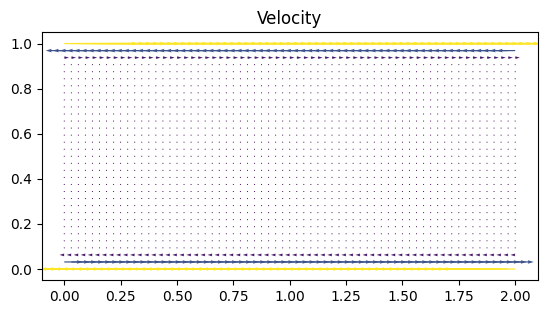

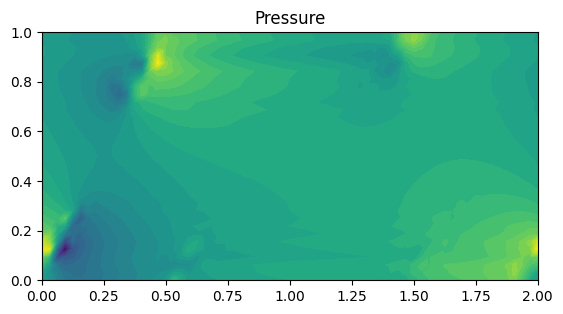

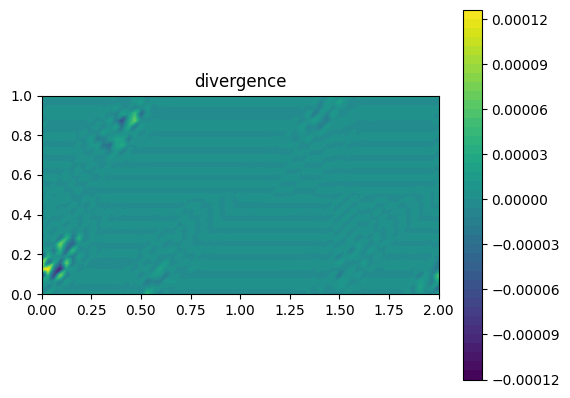

Time t = 2.0108349089992514


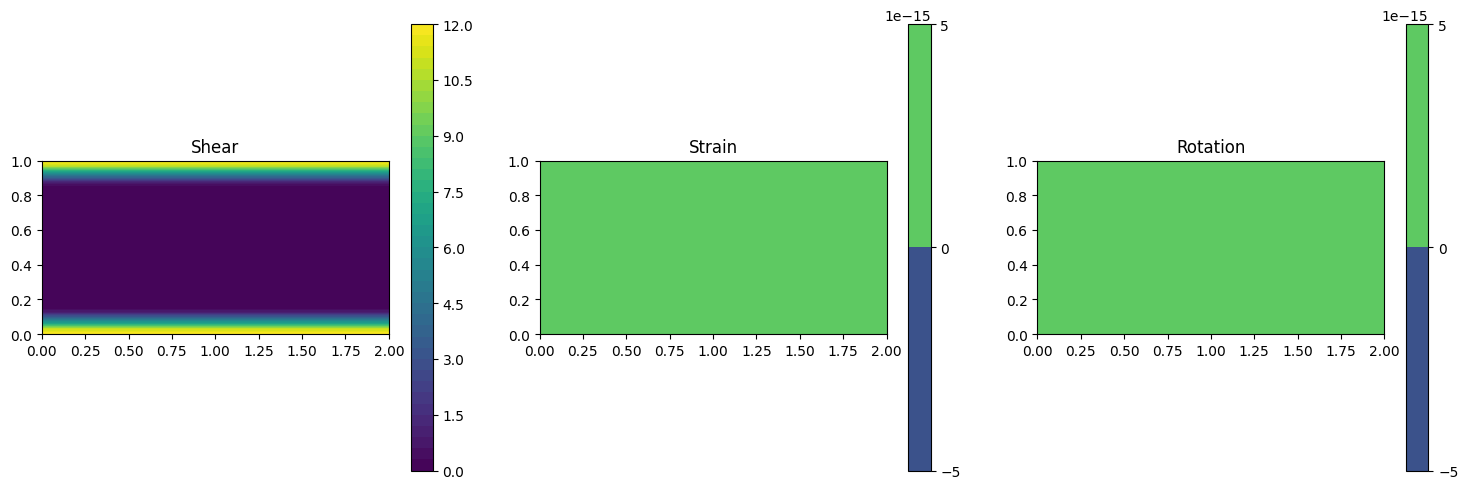

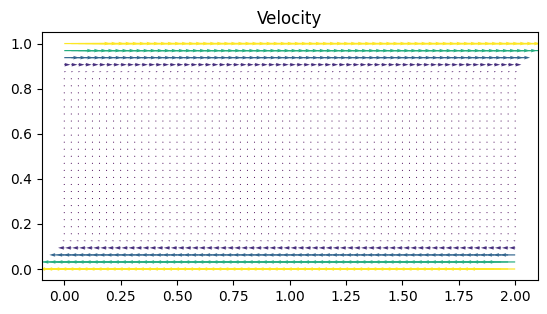

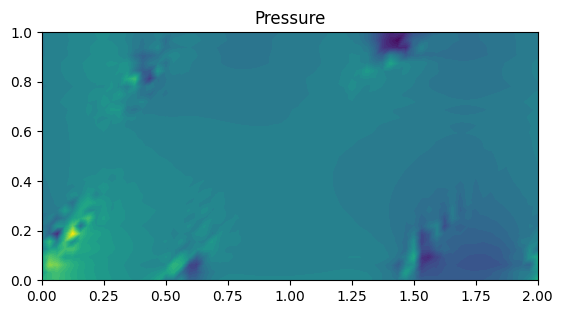

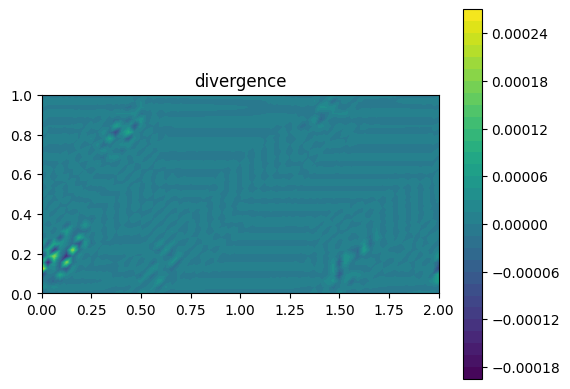

Time t = 4.010621274542472


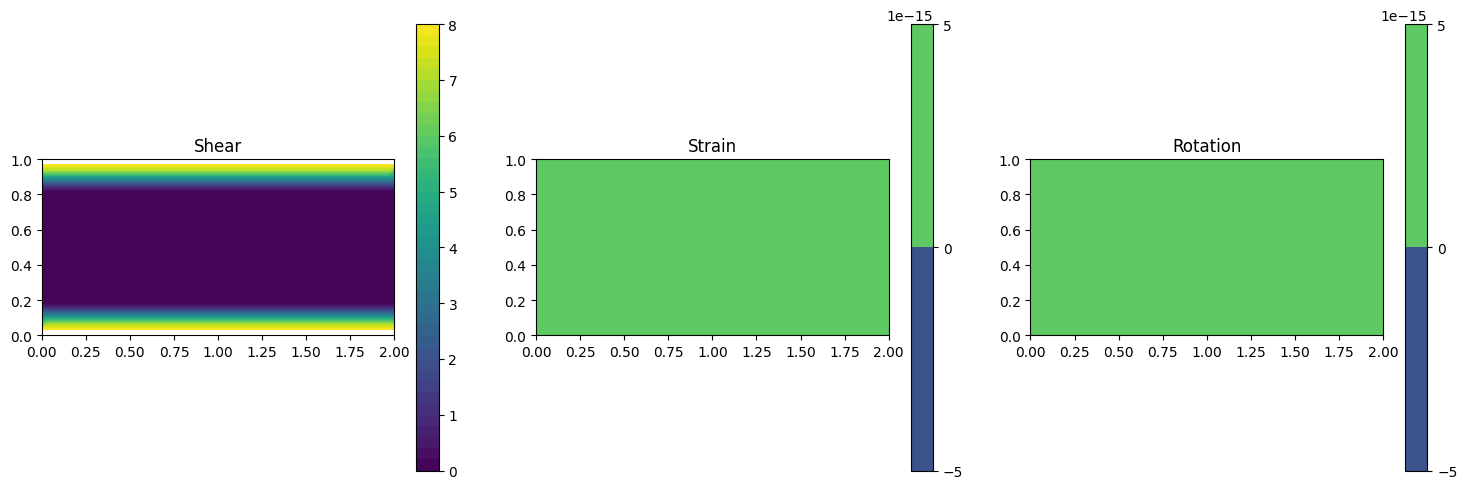

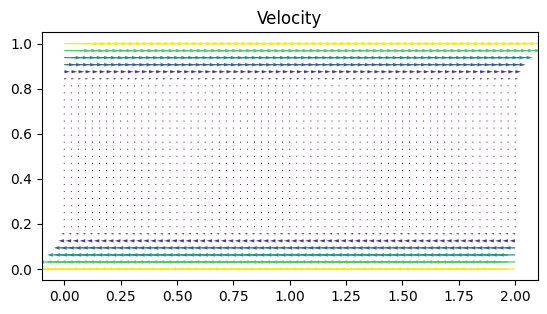

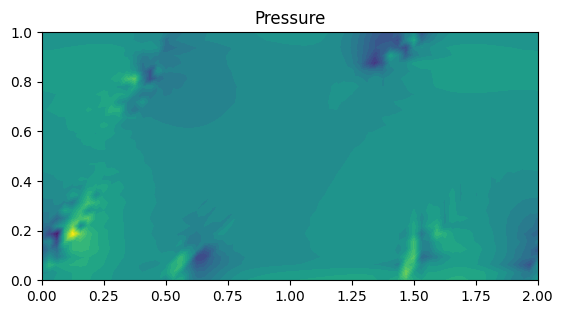

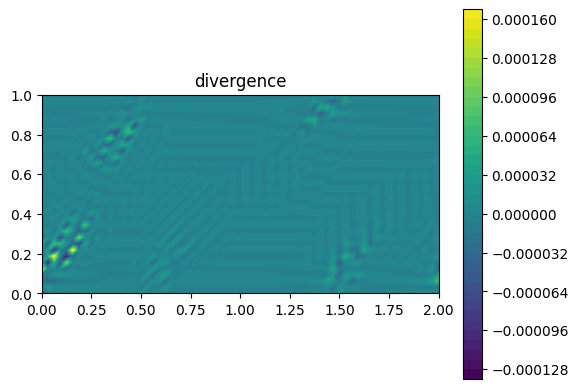

Time t = 6.010407640085693


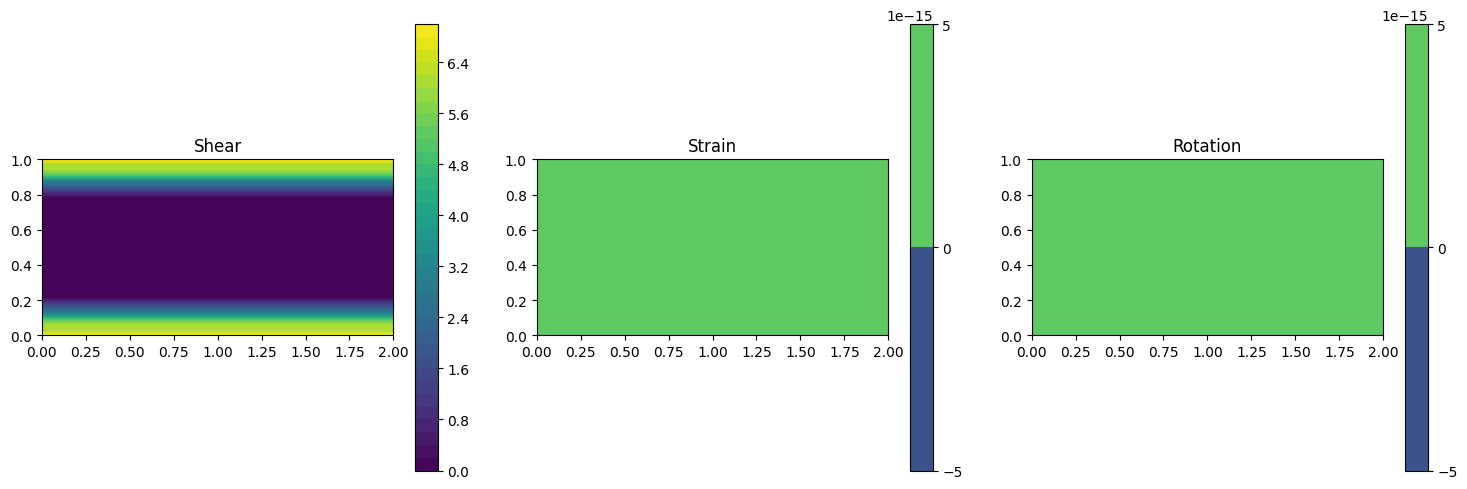

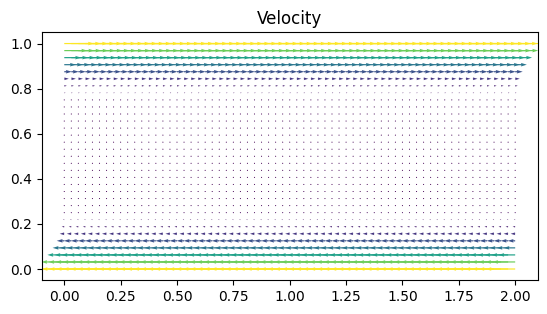

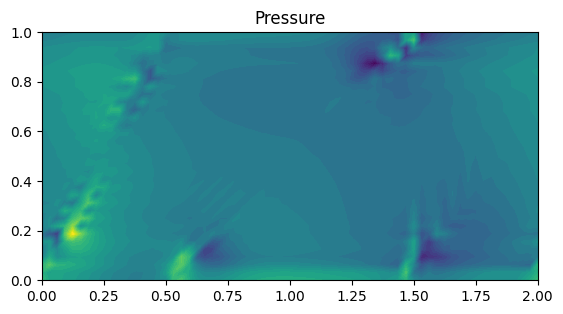

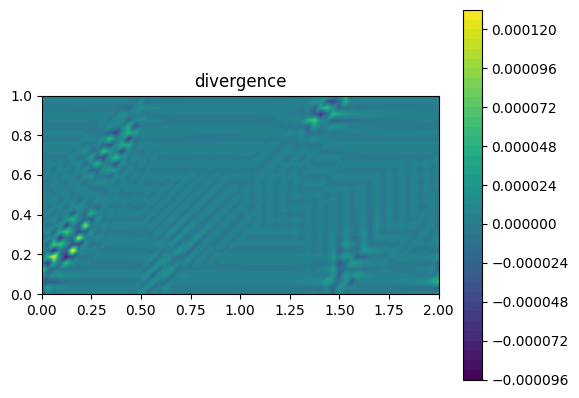

Time t = 8.010194005628913


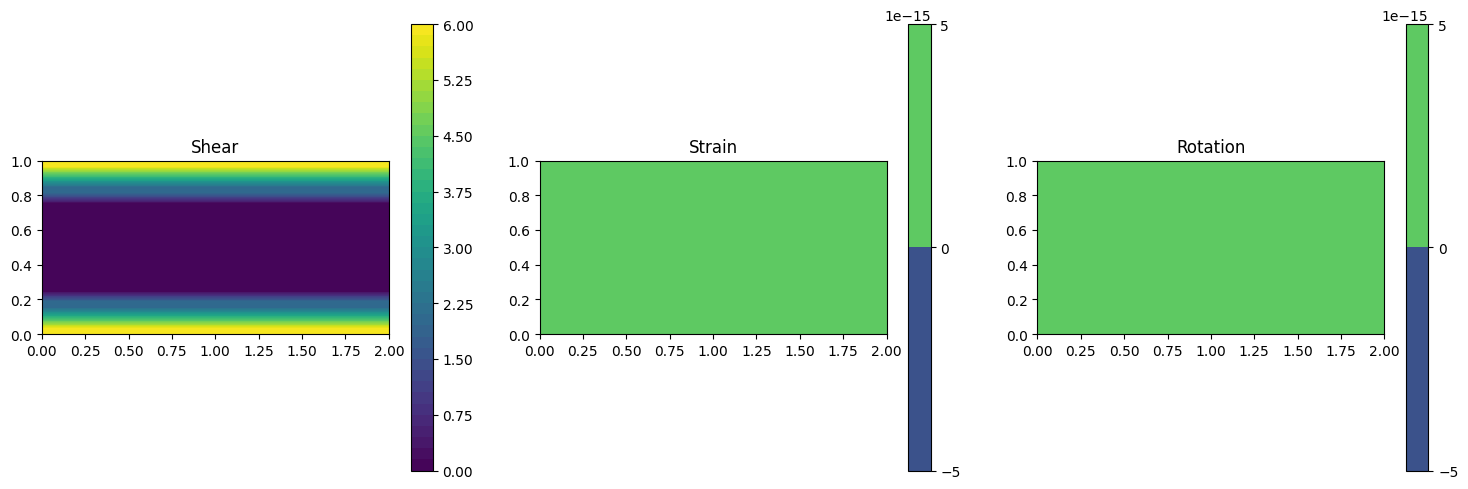

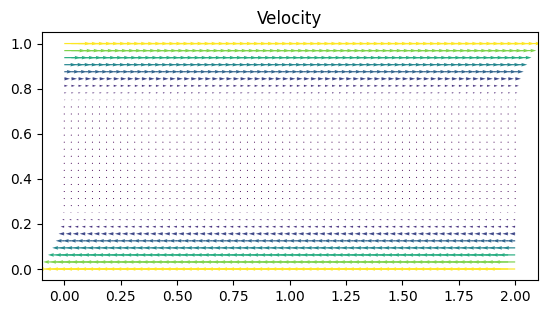

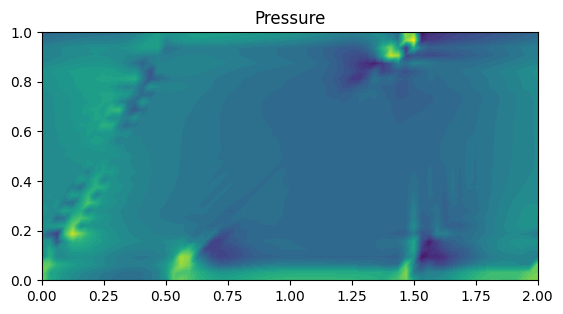

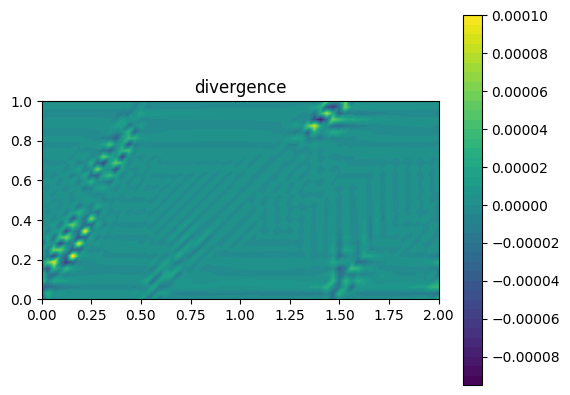

Time t = 10.009980371172134


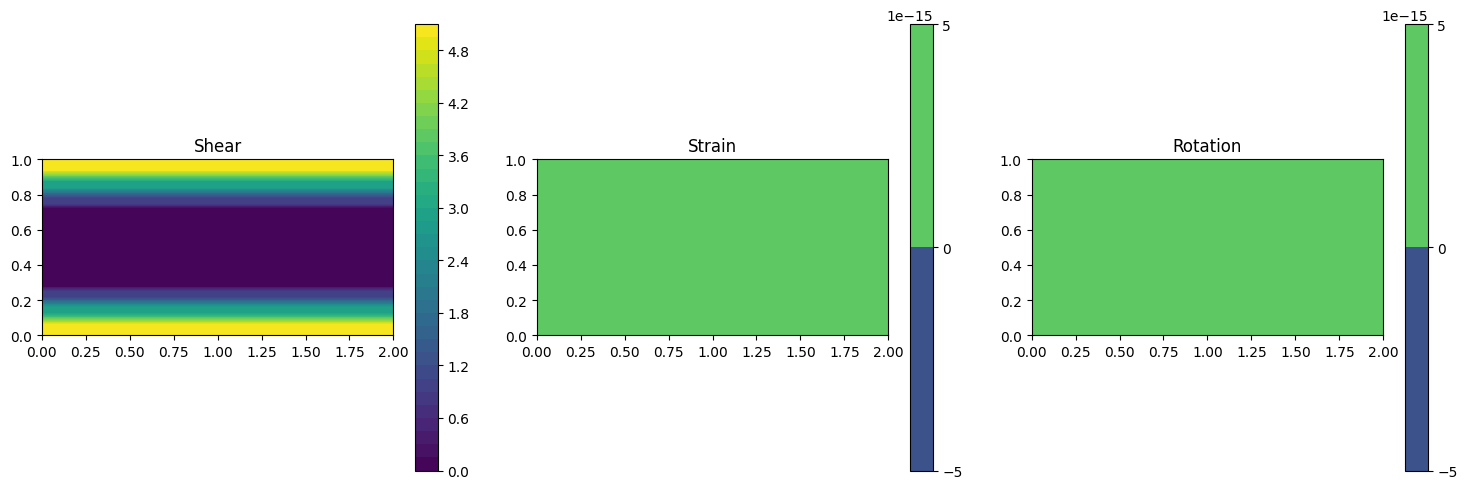

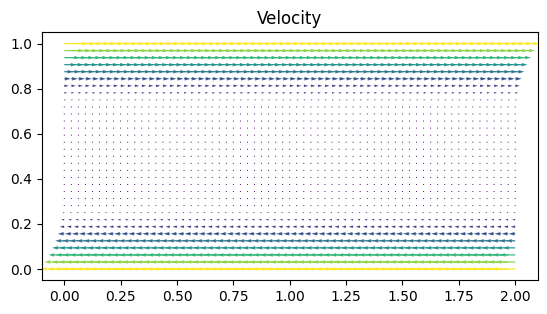

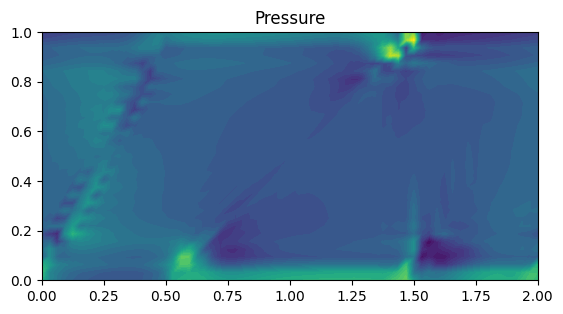

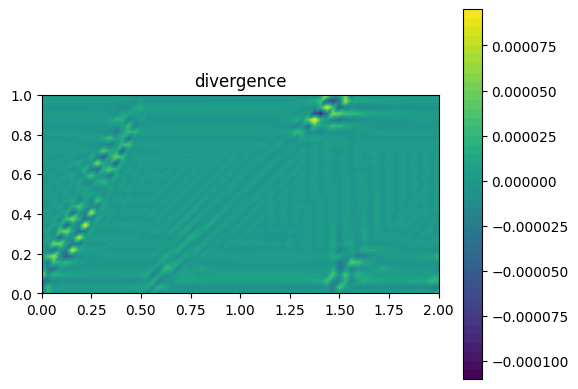

Time t = 12.009766736715354


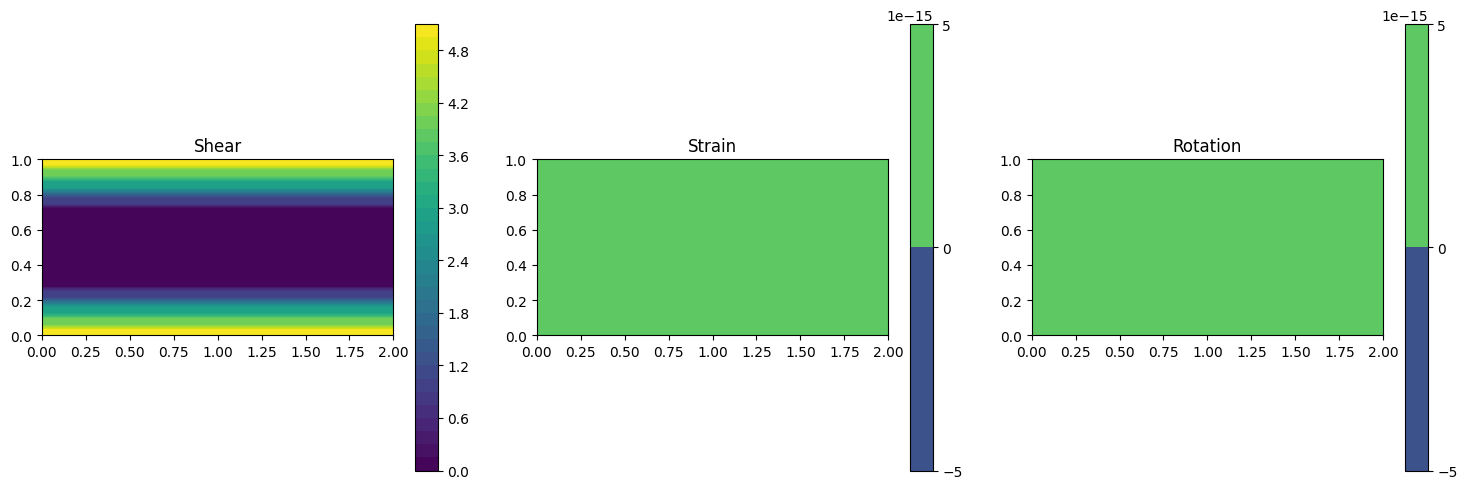

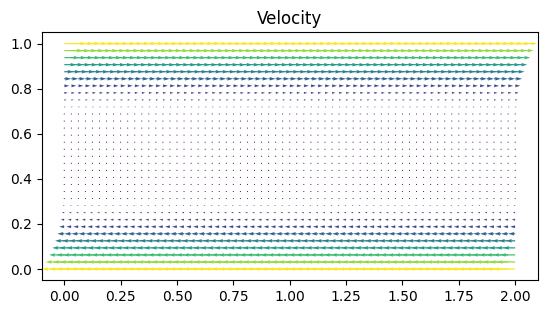

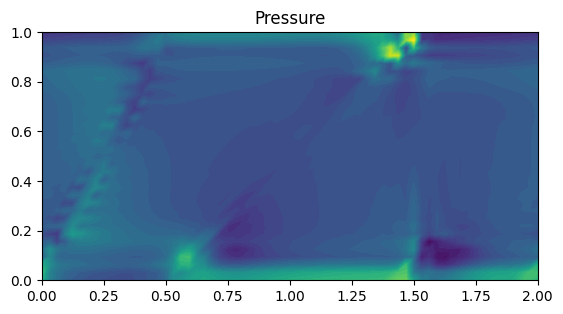

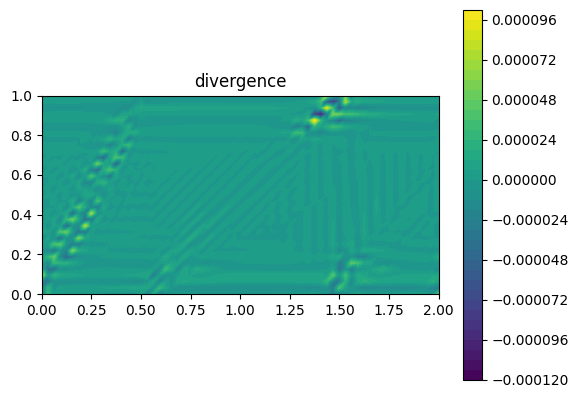

Time t = 14.009553102258575


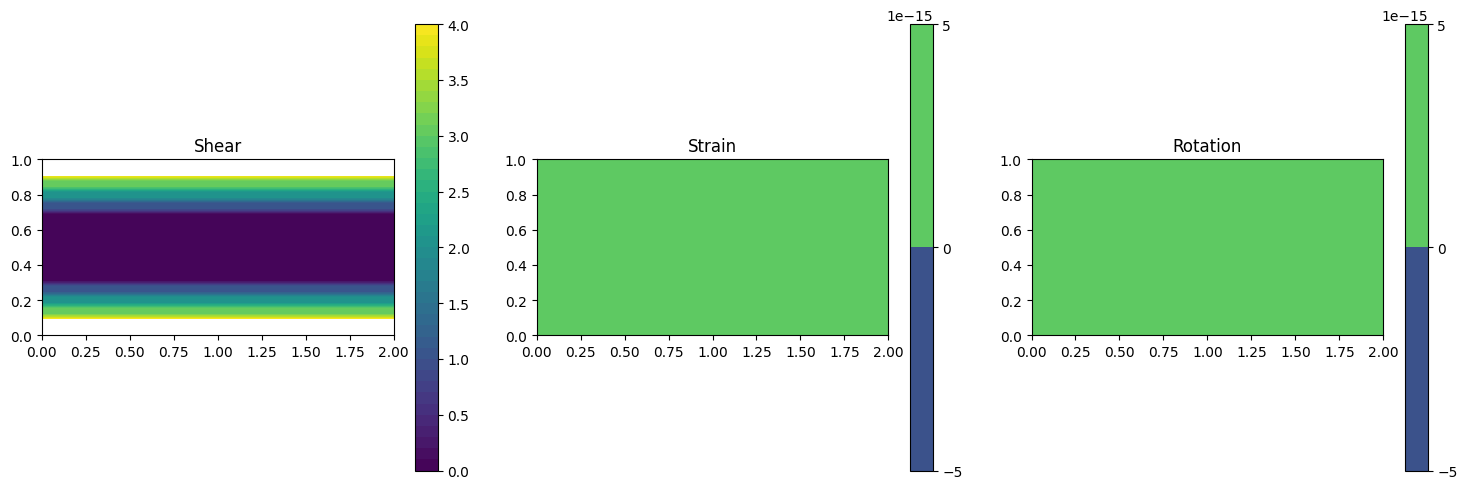

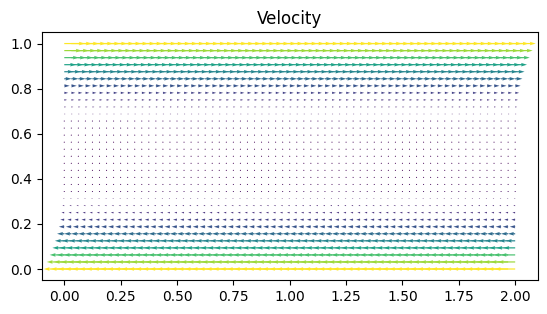

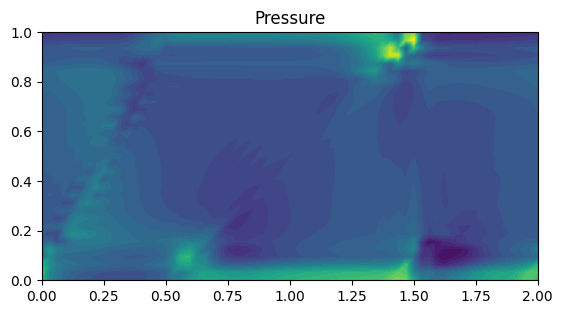

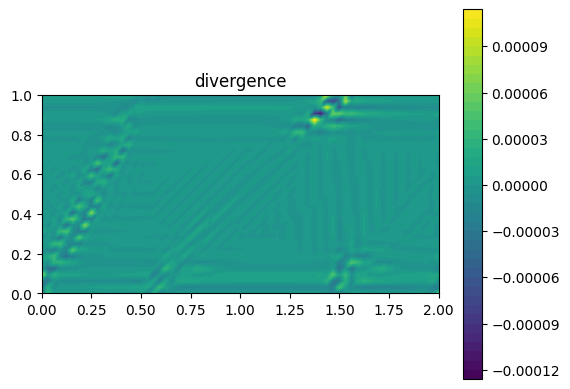

Time t = 16.009339467801794


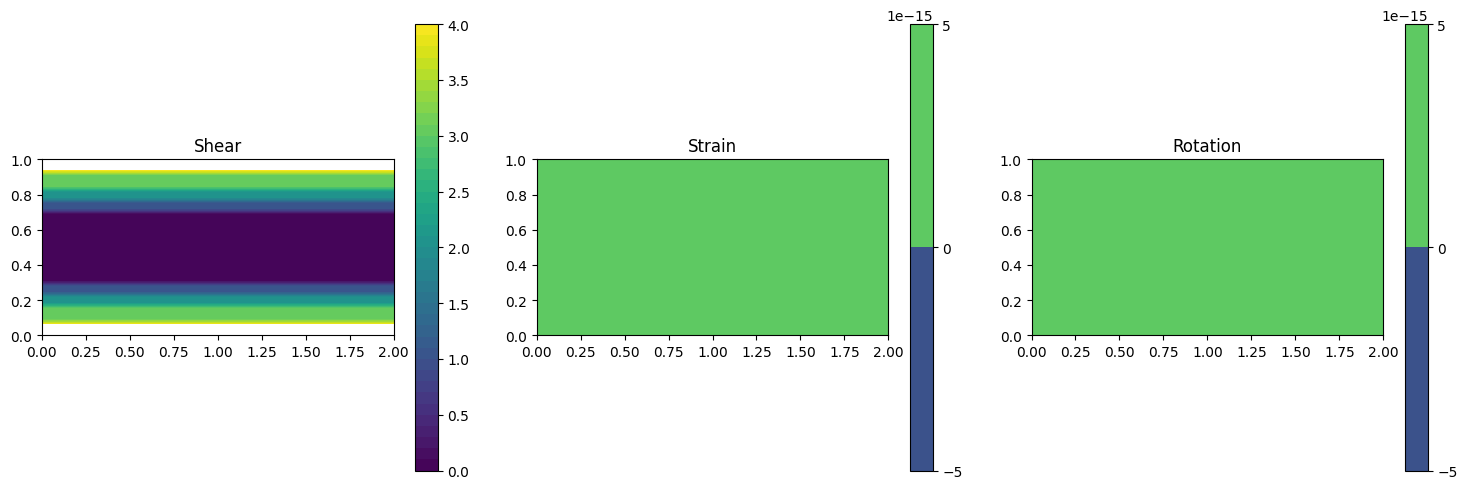

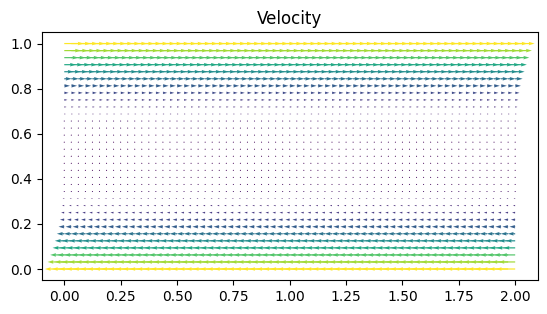

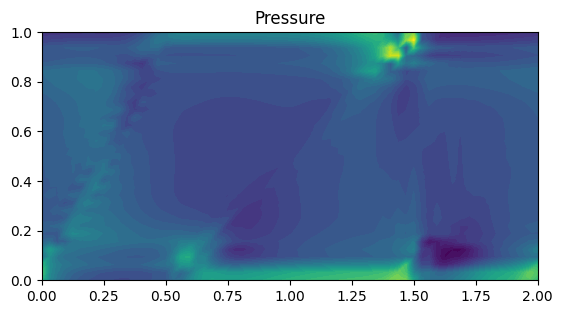

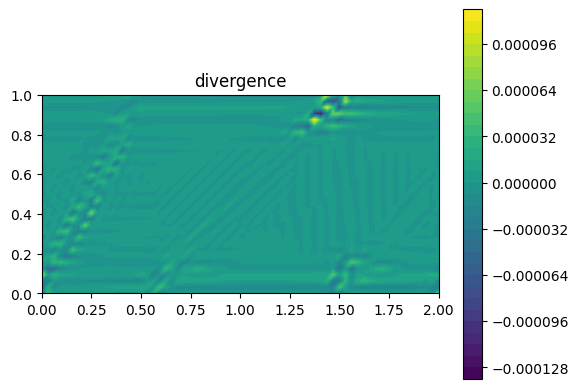

Time t = 18.009125833344694


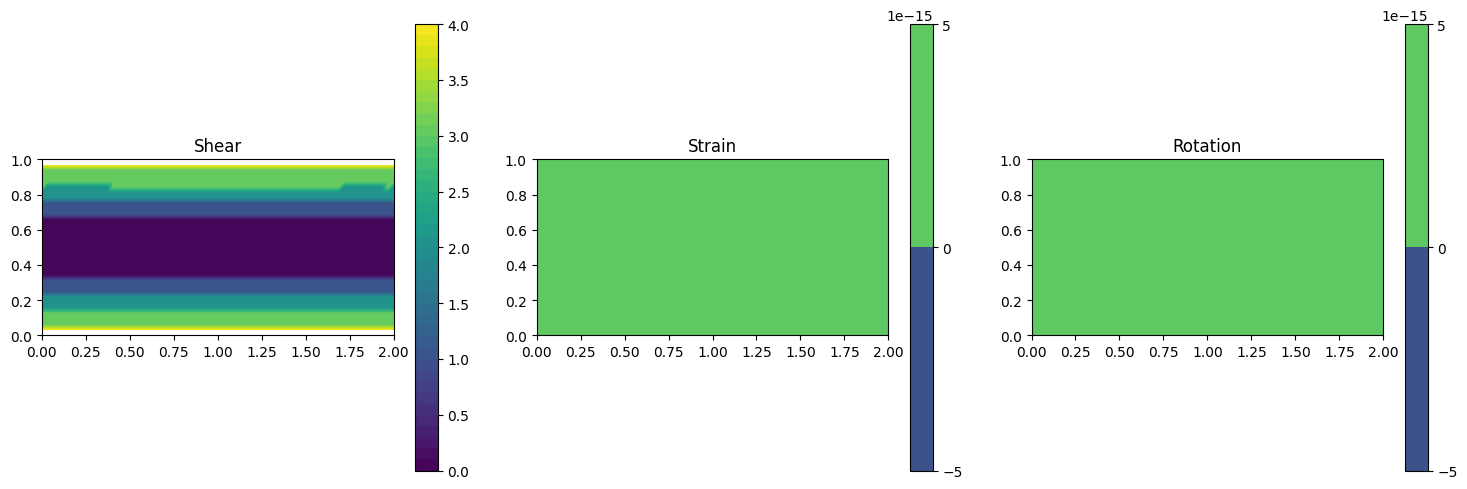

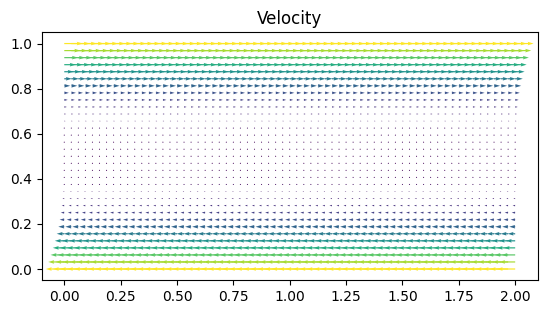

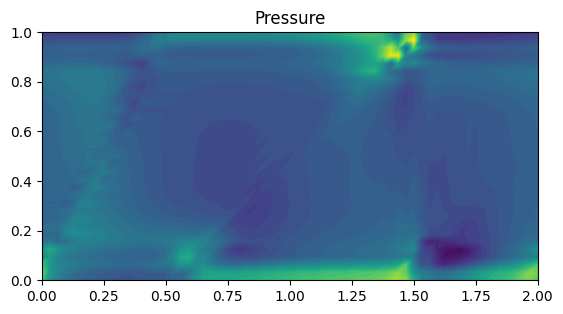

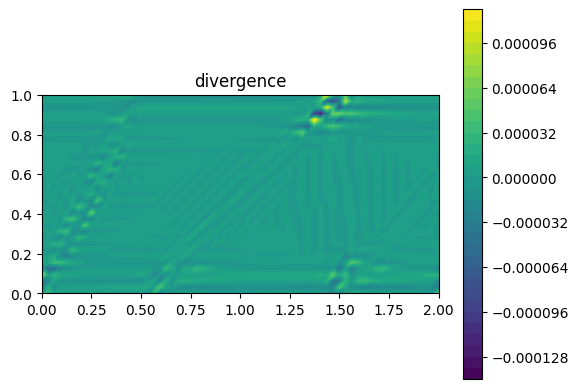

Time t = 20.008912198887593


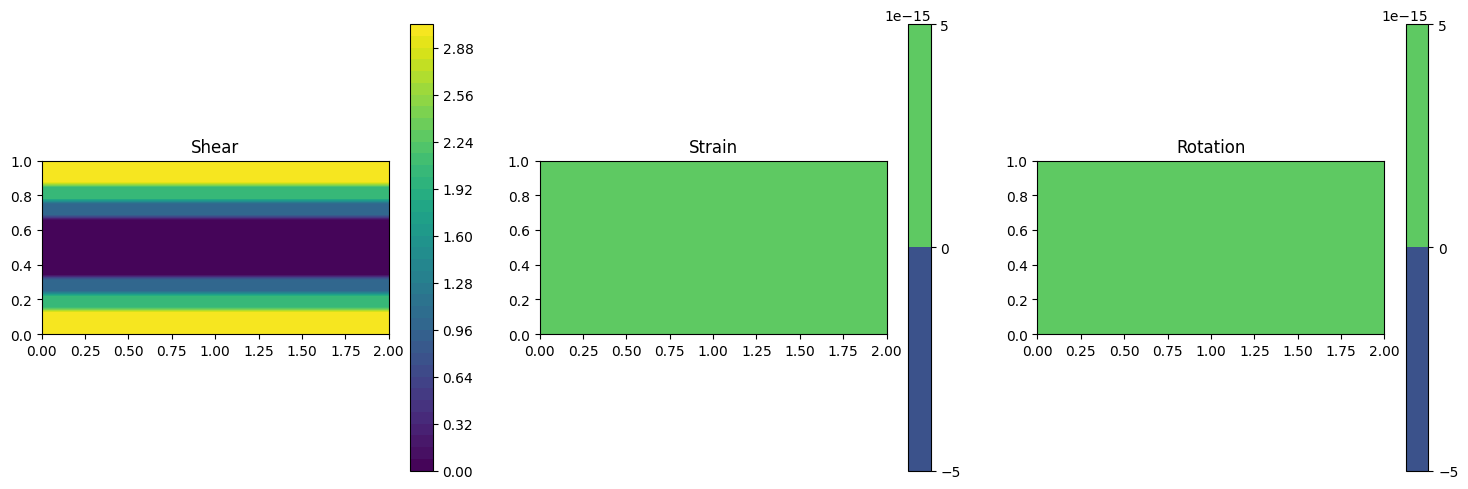

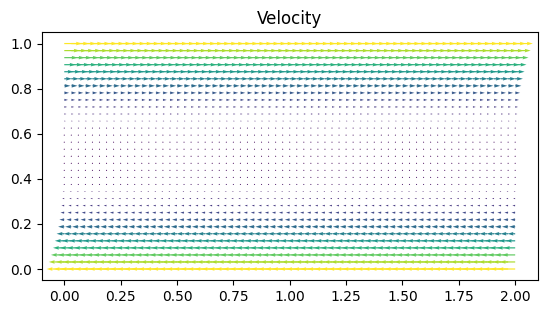

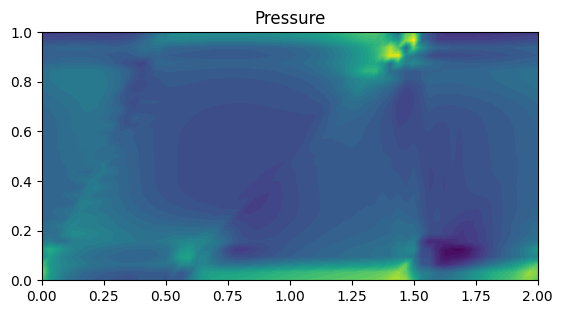

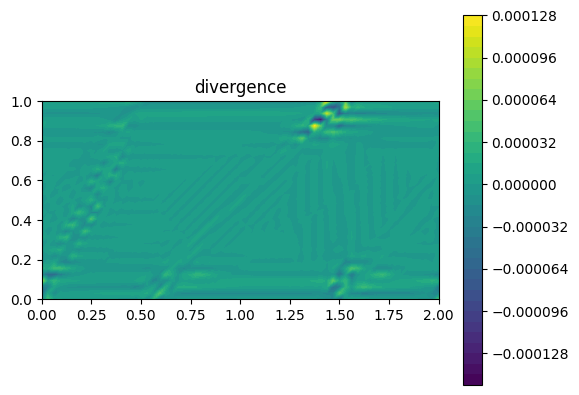

Time t = 22.008698564430492


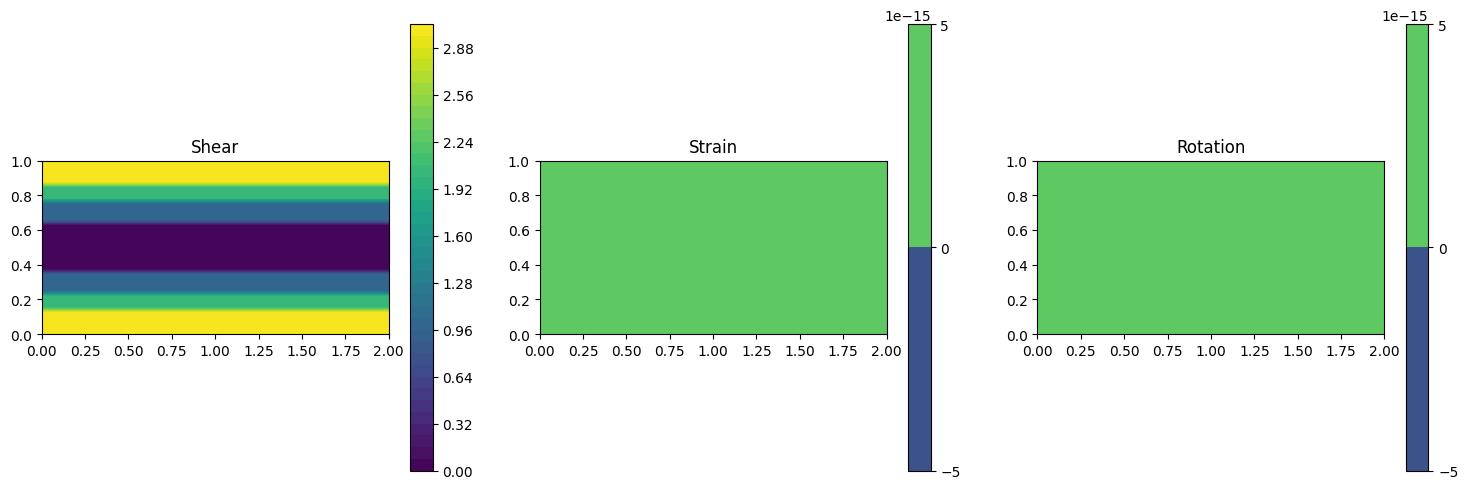

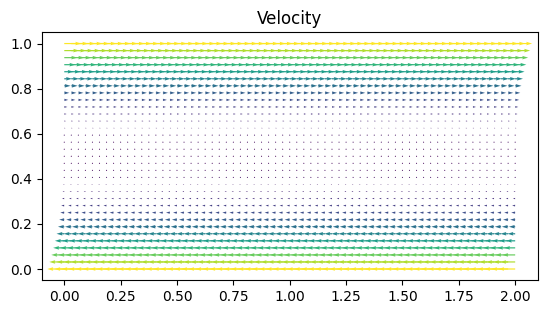

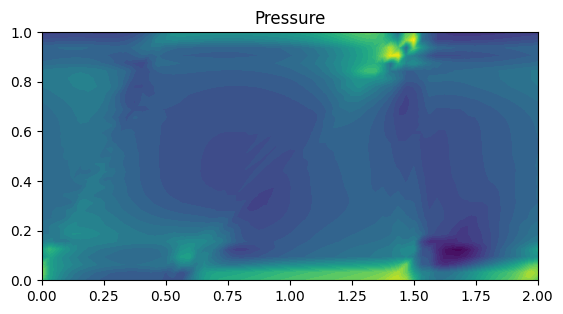

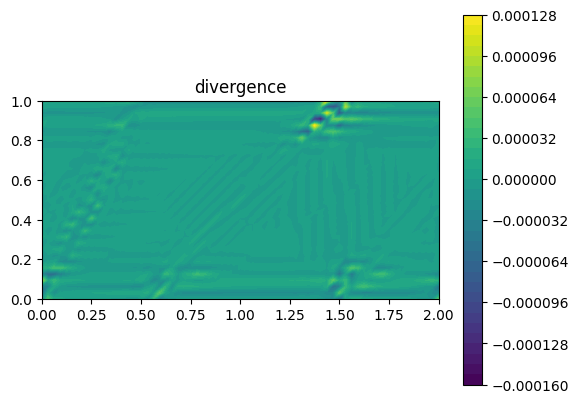

Time t = 24.008484929973392


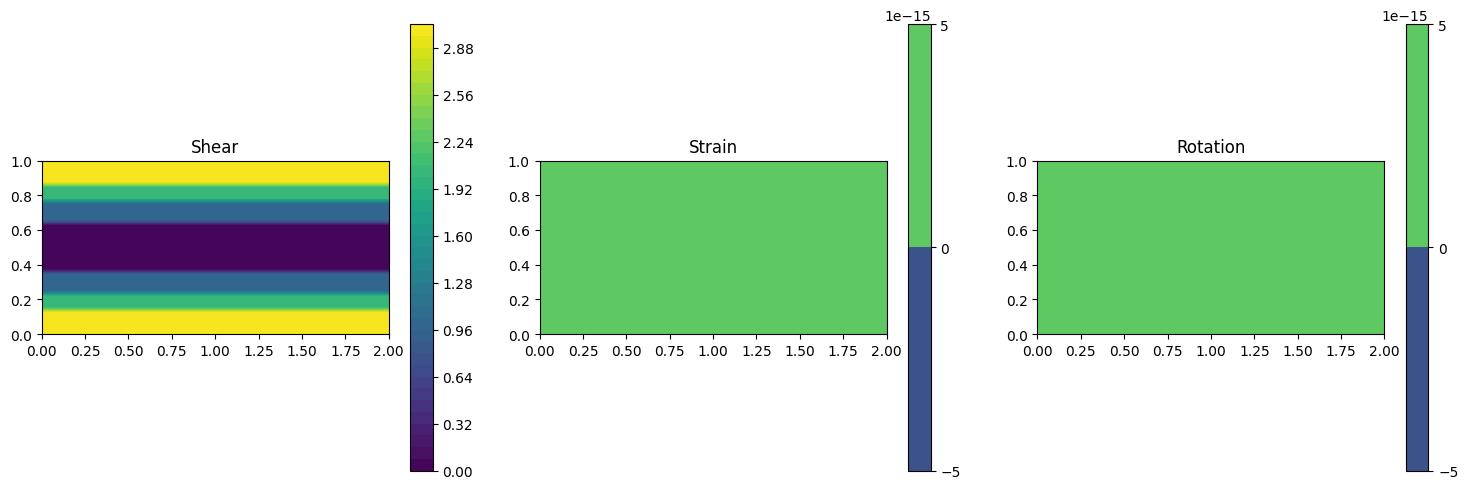

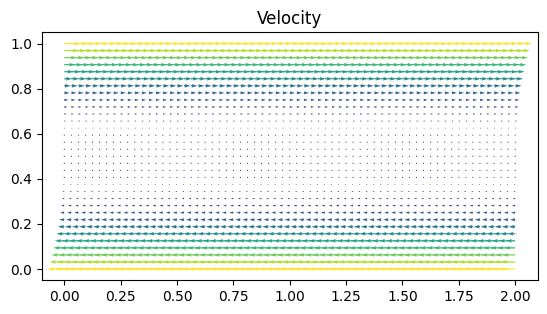

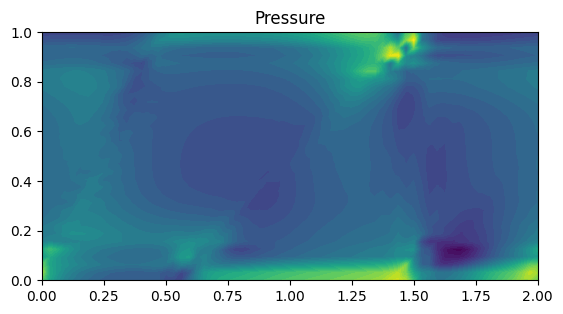

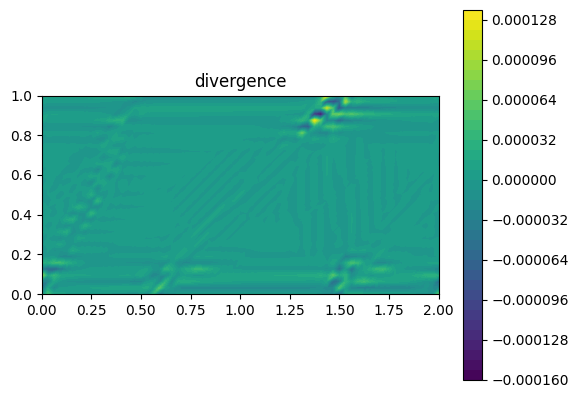

Time t = 26.00827129551629


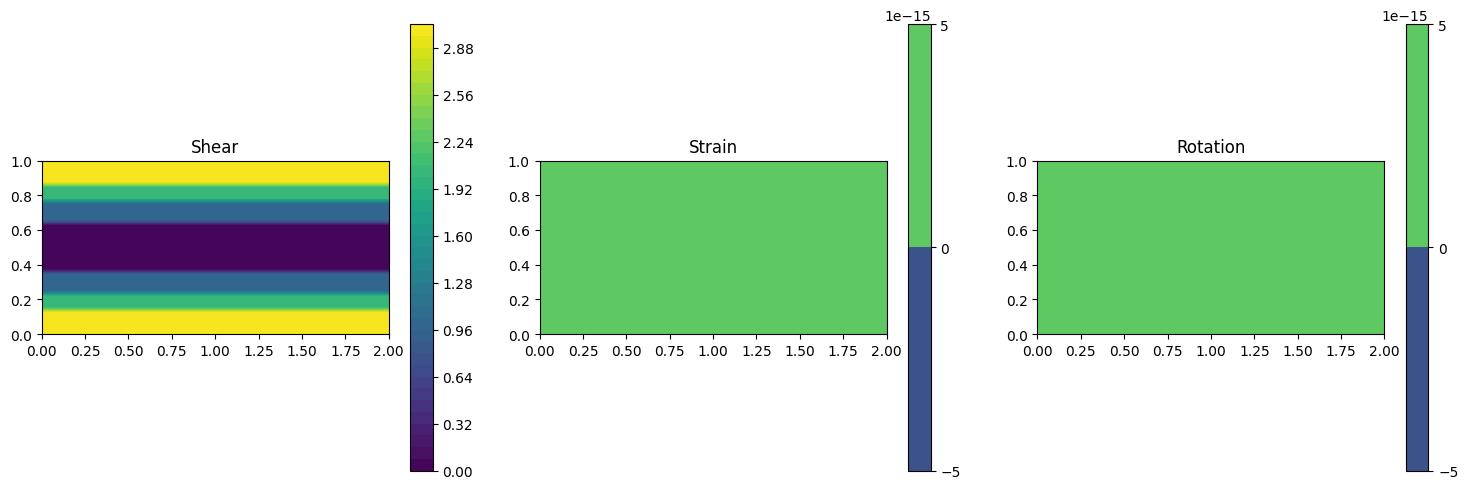

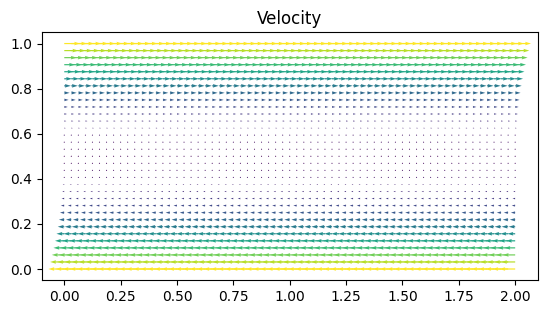

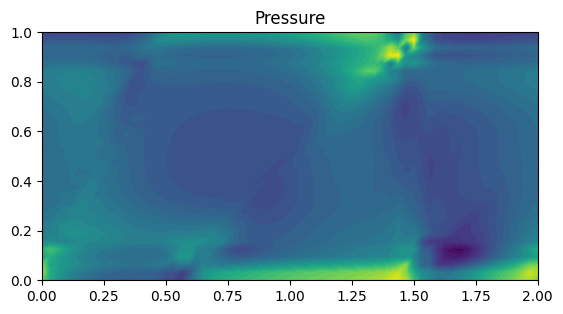

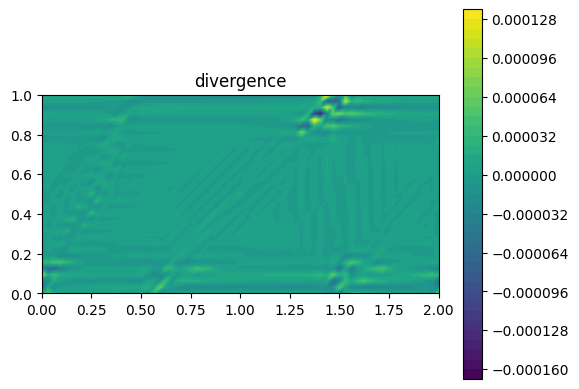

Time t = 28.00805766105919


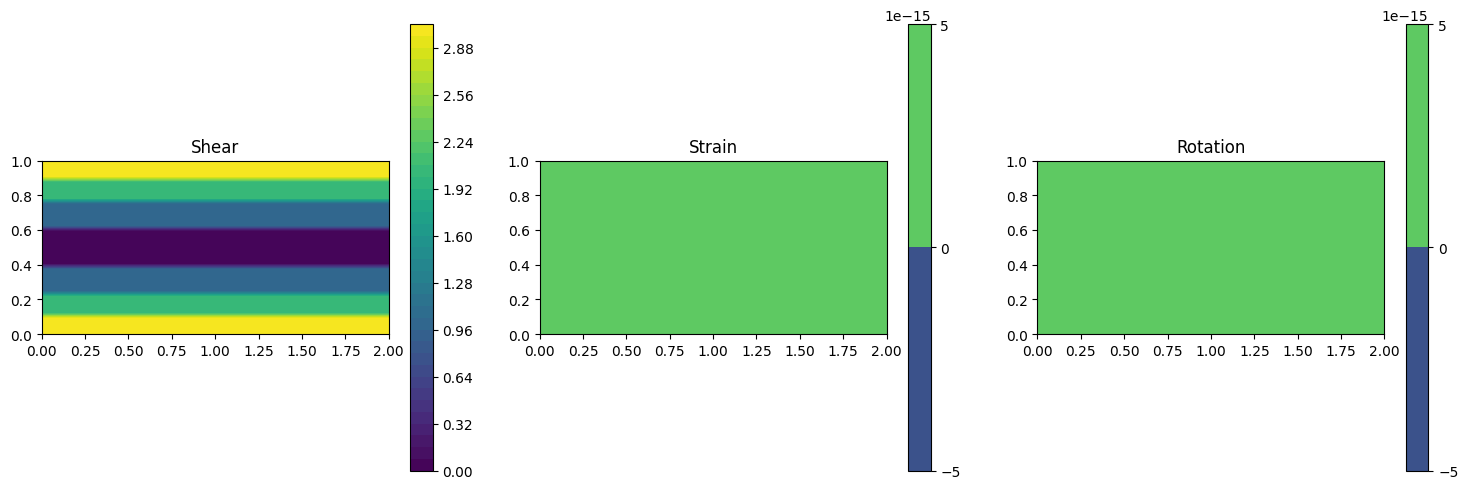

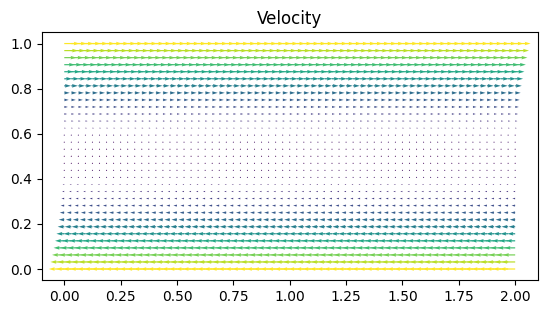

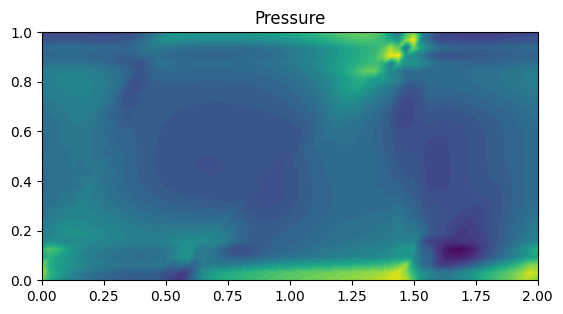

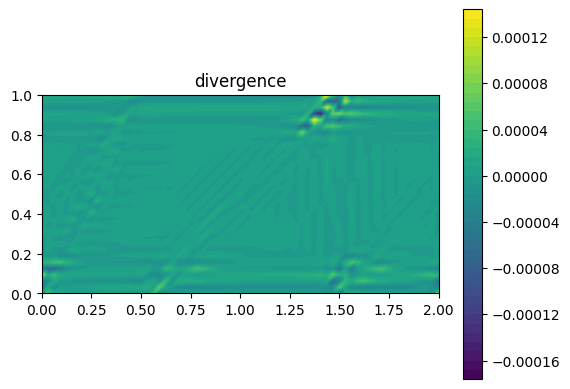

Time t = 30.00784402660209


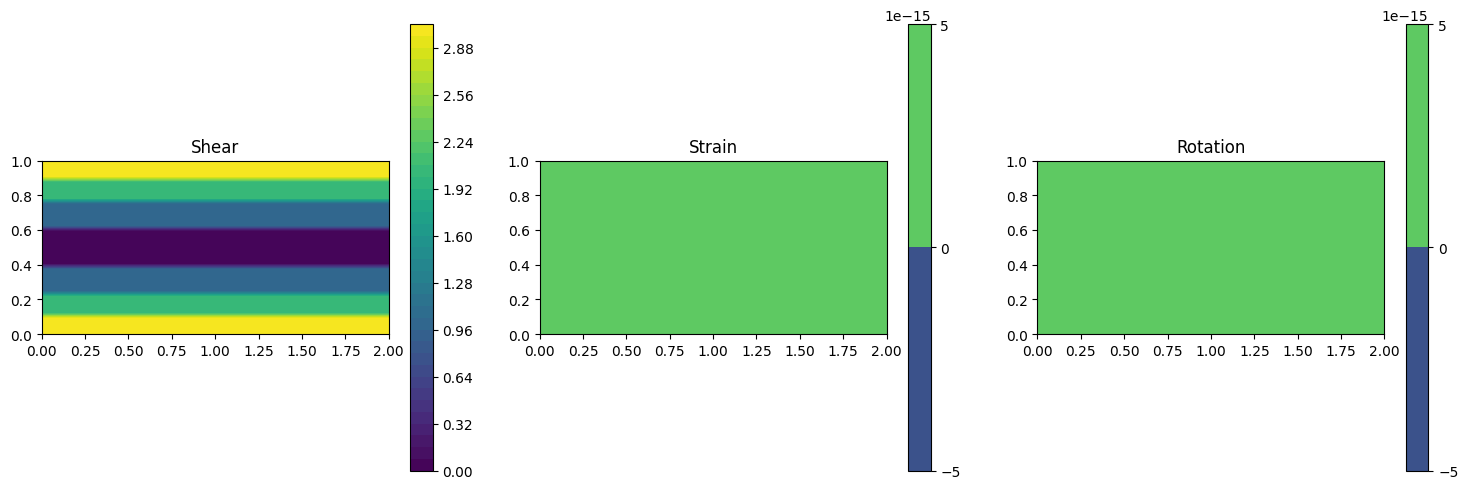

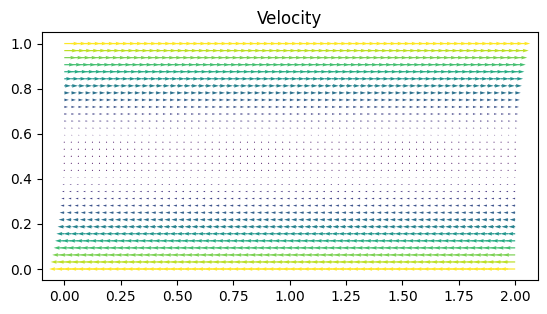

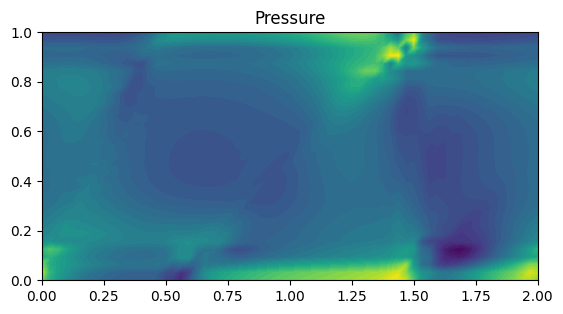

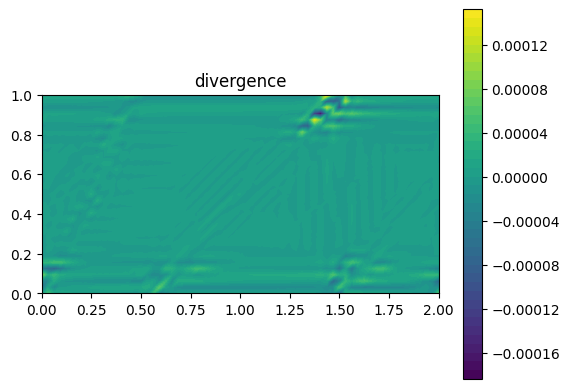

In [ ]:
# Time stepping
T = 80
t = dt
while t < T + DOLFIN_EPS:

    #s = 'Time t = ' + repr(t)
    #print(s)

    # Solve non-linear problem
    k = 0
    while k < num_nnlin_iter:

        # Assemble matrix and vector
        Au = assemble(au)
        bu = assemble(Lu)

        # Compute solution
        [bc.apply(Au, bu) for bc in bcu]
        [bc.apply(u1.vector()) for bc in bcu]
        solve(Au, u1.vector(), bu, "bicgstab", "default")

        # Assemble continuity matrix and vector
        Ap = assemble(ap)
        bp = assemble(Lp)

        # Compute pressure solution
        [bc.apply(Ap, bp) for bc in bcp]
        [bc.apply(p1.vector()) for bc in bcp]
        solve(Ap, p1.vector(), bp, "bicgstab", prec)

        k += 1


    if t > plot_time:

        s = 'Time t = ' + repr(t)
        print(s)

        # Save solution to file
        file_u << u1
        file_p << p1

        V = TensorFunctionSpace(mesh, 'P', 1)
        grad_u1_prel = nabla_grad(u1)
        grad_u1 = project(grad_u1_prel, V)

        V2 = FunctionSpace(mesh, 'CG', 1)
        shear = Function(V2)
        elongation = Function(V2)
        rotation = Function(V2)
        dofmap = V2.dofmap()

        divu = Function(V2)

        for vertex in vertices(mesh):
            point = vertex.point()
            grad_u1_point = grad_u1(point) # Evaluate the gradient tensor at the current point
            grad_u1_matrix = matrix = np.array([
                                                [grad_u1_point[0],grad_u1_point[1] ],
                                                [grad_u1_point[2], grad_u1_point[3]]
                                                                                       ])
            sh, el, rr = triple_decomposition(grad_u1_matrix)
            vertex_index = vertex.index()
            dof_index = vertex_to_dof_map(V2)[vertex_index]
            shear.vector()[dof_index] = sh
            elongation.vector()[dof_index] = el
            rotation.vector()[dof_index] = rr

            divu_vert = grad_u1_point[0] + grad_u1_point[3]
            divu.vector()[dof_index] = divu_vert

        #Plot Triple Decomposition
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        ax = plt.subplot(1, 3, 1)
        im = plot(shear, title = "Shear")
        plt.colorbar(im)
        ax = plt.subplot(1, 3, 2)
        im = plot(elongation, title = "Strain")
        plt.colorbar(im)
        ax = plt.subplot(1, 3, 3)
        im = plot(rotation, title = "Rotation")
        plt.colorbar(im)
        plt.tight_layout()
        plt.show()

        # Plot solution
        plt.figure()
        plot(u1, title="Velocity")

        plt.figure()
        plot(p1, title="Pressure")

        plt.figure()
        im = plot(divu, title="divergence")
        plt.colorbar(im)

        plot_time += T/(plot_freq)

        plt.show()

    # Update time step
    u0.assign(u1)
    t += dt

plt.show()


#!tar -czvf results-Euler-flat.tar.gz results-NS
#files.download('results-Euler-flat.tar.gz')